In [2]:
%run ./PPS_Expansion_Model.ipynb

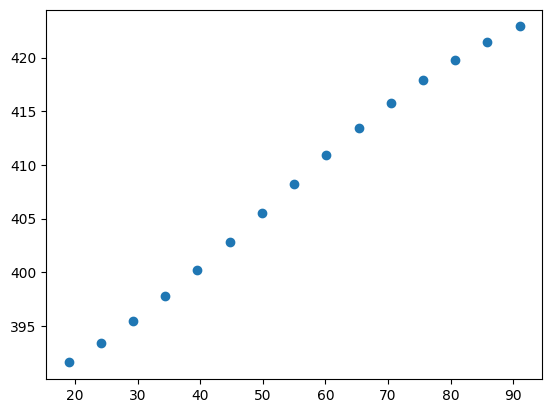

In [3]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
s_distances_sec = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - s_distances_sec * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###SCZ
ymin = 382.5
ymax = 429.5
scz_cp = 100 - 1.6415 * 30
scz_slope = 1 / 0.0450

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)
plt.scatter(a_distances, SCZ_RTs)

In [4]:
from scipy.optimize import differential_evolution

HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=2.603e01,
    k2=7.795e02,
    lim=2.009e01,
    alpha=9.415e-01,
)

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)


def sczmodelrun(theta):
    _, _, _, _, SCZrt = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=SCZLt,
        La=SCZLa,
        Lv=SCZLv,
        Wt=HCWt,
        Wa=HCWa,
        Wv=HCWv,
        Bt=HCBt,
        Ba=HCBa,
        Bv=HCBv,
        Wat=HCWat,
        Wvt=HCWvt,
        Wav=HCWav,
        FWpr=theta[0],
        CMpr=0,
    )

    SCZ_Model_RTs = fit_RT(xf=SCZrt, yf=SCZ_RTs)
    cost = np.sum(np.square(np.divide(SCZ_RTs - (SCZ_Model_RTs), SCZ_RTs)))

    return cost * 100000


bounds = [(0, 6.5)]
sczres = differential_evolution(
    sczmodelrun, bounds, disp=True, workers=30, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 1.2485128872028481
differential_evolution step 2: f(x)= 1.2485128872028481
differential_evolution step 3: f(x)= 1.2485128872028481
differential_evolution step 4: f(x)= 1.2485128872028481
differential_evolution step 5: f(x)= 1.2485128872028481
differential_evolution step 6: f(x)= 1.2485128872028481
differential_evolution step 7: f(x)= 1.2485128872028481


In [6]:
print(sczres)

             message: Optimization terminated successfully.
             success: True
                 fun: 1.2485128872028481
                   x: [ 2.801e-01]
                 nit: 7
                nfev: 120
          population: [[ 2.801e-01]
                       [ 2.360e-01]
                       ...
                       [ 2.835e-02]
                       [ 4.379e-01]]
 population_energies: [ 1.249e+00  1.249e+00 ...  1.249e+00  1.249e+00]


In [7]:
## Fitted model

Pr = 2.801e-01

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)
HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=2.603e01,
    k2=7.795e02,
    lim=2.009e01,
    alpha=9.415e-01,
)

_, _, _, _, SCZ_Model_RTs = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    CMpr=0,
)

SCZ_Model_RTs_scaled = fit_RT(xf=SCZ_Model_RTs, yf=SCZ_RTs)

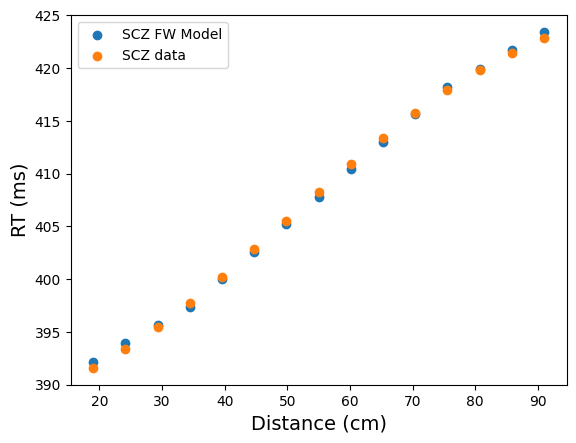

In [8]:
plt.scatter(a_distances, SCZ_Model_RTs_scaled, label="SCZ FW Model")
plt.scatter(a_distances, SCZ_RTs, label="SCZ data")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()

In [10]:
scz_error = calculate_adj_rmse(SCZ_Model_RTs_scaled, SCZ_RTs, 3)
print(scz_error)

0.41338059812332506
